## Self-Check

Detecting Hallucinations in LLM Responses through Log Probabilities

In [1]:
import os
from dotenv import load_dotenv
from openai import OpenAI

#MODEL_ID = "gpt-3.5-turbo"
MODEL_ID = "gpt-4o-mini"

load_dotenv("../keys.env")

assert os.environ["OPENAI_API_KEY"][:2] == "sk", "Please sign up for access to the OpenAI API and provide access token in keys.env file"

In [2]:
# Initialize the client
client = OpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
)

## Lower confidence on wrong imputations

In [3]:
import pandas as pd
import numpy as np
from io import StringIO

def parse_result(response_text, logprobs) -> pd.DataFrame:
    """
    Assuming that the format of the result string is

    billed_amount, tip, paid_amount
    billed_amount, tip, paid_amount
    ...

    returns a Pandas DataFrame containing the following columns:
    billed_amount, tax, tip, paid_amount, confidence
    """
    csv_file = StringIO(response_text)
    result_df = pd.read_csv(csv_file, header=None, names=['billed_amount', 'tax', 'tip', 'paid_amount'], dtype=np.float64)
    result_df['confidence'] = [0.0]*len(result_df)
    
    if not logprobs:
        print("No logprobs available in the response")
        return result_df
    
    # Walk through the tokens and combine them into elements
    # so that tokens are associated with the elements
    line_no = 0
    confidence_of_line = 1.0
    last_col_no = len(result_df.iloc[0]) - 1
    for token_info in logprobs.content:
        token = token_info.token
        logprob = token_info.logprob
        probability = (2.718281828459045 ** logprob)
        confidence_of_line = min(confidence_of_line, probability)
        result_df.iloc[line_no, last_col_no] = confidence_of_line 
        # int(token, probability, end="; ")
        
        if '\n' in token: # next line
            line_no = line_no + 1
            confidence_of_line = 1.0
            # int()
            
    return result_df


def get_response_with_confidence(in_data: str, model: str = MODEL_ID) -> pd.DataFrame:
    """Get a model response with confidence analysis for a given question."""
    # Make the API call
    message = client.chat.completions.create(
        model=model,
        max_tokens=512,
        temperature=0,
        messages=[
            {
                "role": "system",
                "content": """
                You are a helpful AI assistant that helps parse restaurant receipts.
                I will give you a set of parsed values containing on each line:
                
                billed_amount, tax, tip, paid_amount
                
                If tax is missing, calculate it as 9.21% of the billed_amount
                If the tip is missing, calculate it as (paid_amount - billed_amount - tax)
                If the paid_amount is missing, calculate it as (billed_amount + tax + tip)
                Do not add any headers or explanations.
                """
            },
            {
                "role": "user",
                "content": in_data
            }
        ],
        logprobs=True
    )

    return parse_result(response_text=message.choices[0].message.content, 
                        logprobs=message.choices[0].logprobs)

def verify_dataframe(df):
    def verify_row(row):
        calculated_amount = round(row['billed_amount']*1.0921,2) + row['tip']
        return abs(calculated_amount - row['paid_amount'])
    df['error'] = df.apply(verify_row, axis=1)
    return df

In [4]:
# Try with a bit of data
df = get_response_with_confidence("""312.32,28.76,60,401.08
312.32,28.76,,400
312.32,28.76,60,
312.21,,50, 
312.43,,,400
300,27.63,60,387.63
""")
df

,billed_amount,tax,tip,paid_amount,confidence
0,312.32,28.76,60.0,401.08,0.962668
1,312.32,28.76,60.0,400.00,0.551552
2,312.32,28.76,60.0,400.08,0.562172
3,312.21,28.84,50.0,391.05,0.172516
4,312.43,28.80,60.0,401.23,0.170295
5,300.00,27.63,60.0,387.63,0.999290


In [5]:
verify_dataframe(df)

,billed_amount,tax,tip,paid_amount,confidence,error
0,312.32,28.76,60.0,401.08,0.962668,0.00
1,312.32,28.76,60.0,400.00,0.551552,1.08
2,312.32,28.76,60.0,400.08,0.562172,1.00
3,312.21,28.84,50.0,391.05,0.172516,0.09
4,312.43,28.80,60.0,401.23,0.170295,0.03
5,300.00,27.63,60.0,387.63,0.999290,0.00


/opt/conda/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


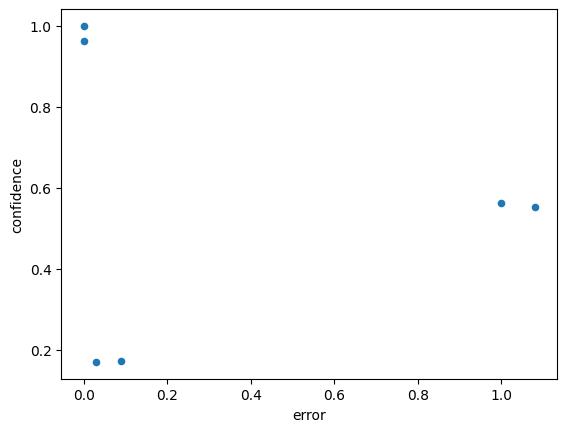

In [6]:
df.plot.scatter(x='error', y='confidence', cmap='viridis');